In [3]:
from helper_code import *
import scipy
from scipy.signal import butter, lfilter
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams

rcParams['figure.figsize'] = 25, 15

In [3]:
# Bandpass filter for preprocessing
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

### Schmidt Spike Removal

number of windows : 40
window_num : 7
spike position : 3
spike start: 1
spike end: 4
[ 5.53179423e+03  7.56878781e+02 -3.90913744e+02 -7.84749933e+03
  4.28747563e+01 -3.47142494e+02 -2.17992866e+02 -6.67453202e+01
  6.98420460e+00  2.38629229e+01 -1.36814407e+02  2.69807191e+02
  1.78427679e+02 -2.94777936e+02  2.93783340e+02 -1.50035164e+03
  3.80760959e+02  5.79861210e+02  2.51133697e+01 -1.85374427e+02
  9.42136213e-01  3.75403158e+02 -1.14540771e+02  3.58816148e+02
 -7.85845130e+02  2.26085835e+02 -9.66490232e-02  4.50328779e+02
  2.60944781e+02 -8.44230676e+01 -1.20052136e+02  1.50287634e+02
 -5.02014639e+02  6.22993984e+02  7.75643039e+01 -1.73907607e+02
  2.12749547e+02  7.03364682e+01 -6.57288831e+01 -3.76860717e+02]
[ 5.53179423e+03  1.00000000e-04  1.00000000e-04  1.00000000e-04
  1.00000000e-04 -3.47142494e+02 -2.17992866e+02 -6.67453202e+01
  6.98420460e+00  2.38629229e+01 -1.36814407e+02  2.69807191e+02
  1.78427679e+02 -2.94777936e+02  2.93783340e+02 -1.50035164e+03
  3.

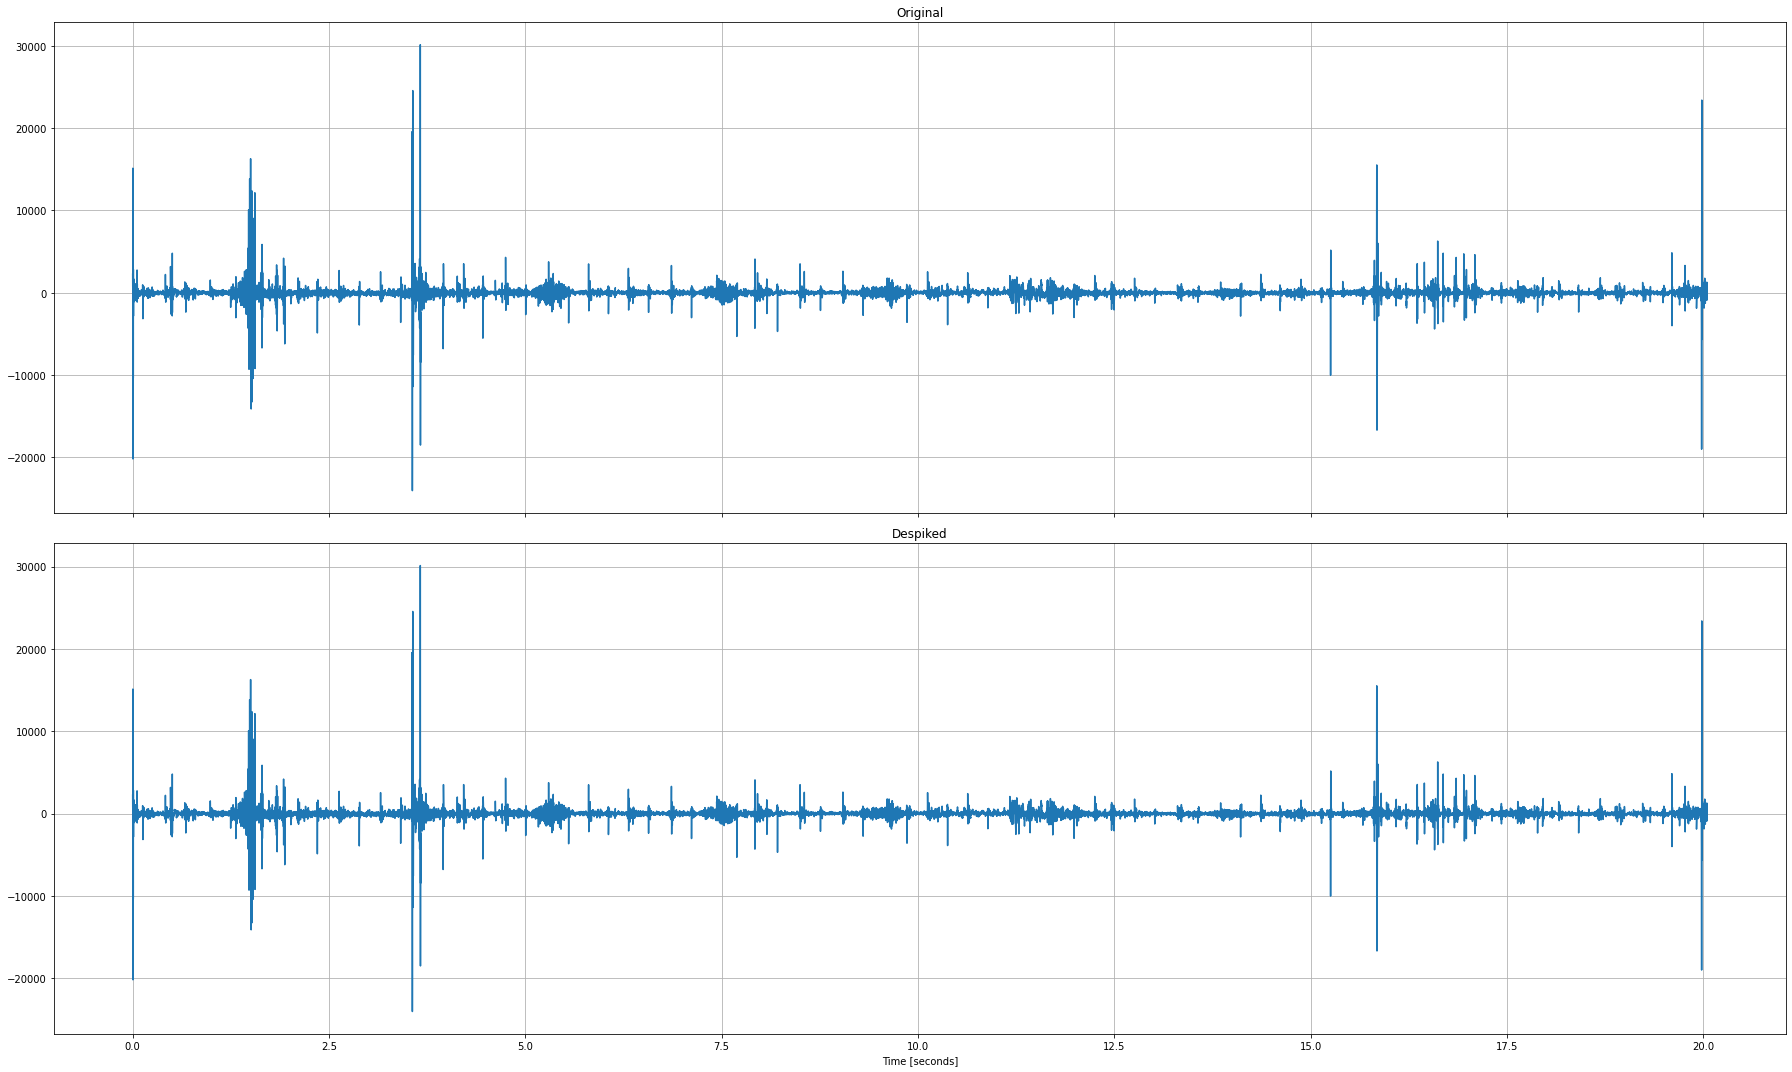

In [46]:
filename = "C:/Users/lumin/Desktop/Work/20212/Data/physionet.org/files/circor-heart-sound/1.0.3/training_data/14241_MV.wav"
frequency, original_signal = sp.io.wavfile.read(filename)

fs = 1000
# Resampling file to 1000 Hz
scale = fs / frequency
# calculate new length of sample
nsamples = round(len(original_signal) * scale)

original_signal = sp.signal.resample(original_signal, nsamples)

# visualize
T = nsamples / NEW_SAMPLING_RATE
t = np.linspace(0, T, nsamples, endpoint=False)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(t, original_signal)
ax1.set_title('Original')

# 
no_sweeps = 0
max_sweeps = 10000

# Find the window size (500 ms)
window_size = round(fs/2)

cur_signal = np.copy(original_signal)
# Find any samples outside of an integer number of windows
trailing_samples = len(cur_signal) % window_size

# Reshape the original signal into a number of windows
sample_frames = np.reshape(cur_signal[:len(cur_signal)-trailing_samples], [-1, window_size])

# Find the MAAs
MAAs = np.amax(abs(sample_frames), axis=1)
print(f'number of windows : {len(MAAs)}')

# While there are still samples greater than 3 * the median value of MAAs, remove those spikes
while any(maa > 3 * np.median(MAAs) for maa in MAAs) and no_sweeps <= max_sweeps:
    no_sweeps += 1
    # Find the window with the max MAA
    val = np.amax(MAAs)
    window_num = np.where(MAAs == val)[0][0]
    print(f'window_num : {window_num}')

    # Find the position of the spike within that window
    spiked_frame = sample_frames[:, window_num] 

    val = np.amax(abs(spiked_frame))
    spike_position = np.where(abs(spiked_frame) == val)[0][0]
    print(f'spike position : {spike_position}')

    # Finding zero crossings (where there may not be actual 0 values, just a change from positive to negative)
    zero_crossings = np.where(np.diff(np.sign(spiked_frame)))[0] # index

    # Find the start of the spike, finding the last zero crossing before spike position. If that is empty, take the start of the window:
    try:
        spike_start = zero_crossings[np.nanargmax(np.where(zero_crossings < spike_position,zero_crossings,np.nan))]
    except:
        spike_start = 0
    print(f'spike start: {spike_start}')
    # Find the end of the spike, finding the first zero crossing after spike position, If that is empty, take the end of the window
    try:
        spike_end = zero_crossings[np.nanargmin(np.where(zero_crossings > spike_position,zero_crossings,np.nan))]
    except:
        spike_end = len(spiked_frame) - 1
    print(f'spike end: {spike_end}')

    # Set to zero
    print(sample_frames[:, window_num])
    sample_frames[spike_start : spike_end + 1, window_num] = 0.0001   
    print(sample_frames[:, window_num])

    # Recalculate MAAs  
    MAAs = np.amax(abs(sample_frames), axis=1)

despiked_signal = sample_frames.flatten()
# Add the trailing samples back to the signal
despiked_signal = np.hstack((despiked_signal, cur_signal[len(despiked_signal) :]))

a = original_signal - despiked_signal
b = [x for x in list(a) if x != 0]
print(b)  

ax2.plot(t, despiked_signal)
ax2.set_title('Despiked')
ax2.set_xlabel('Time [seconds]')
plt.tight_layout()
ax1.grid()
ax2.grid()
plt.show()

In [37]:
# R = np.correlate(original_signal, despiked_signal)
# R = np.corrcoef(original_signal, original_signal)
# R

# a = original_signal - despiked_signal
a = original_signal - np.hstack((despiked_signal, original_signal[len(despiked_signal) :]))
b = [x for x in list(a) if x != 0]
b  


[]

# Preprocess

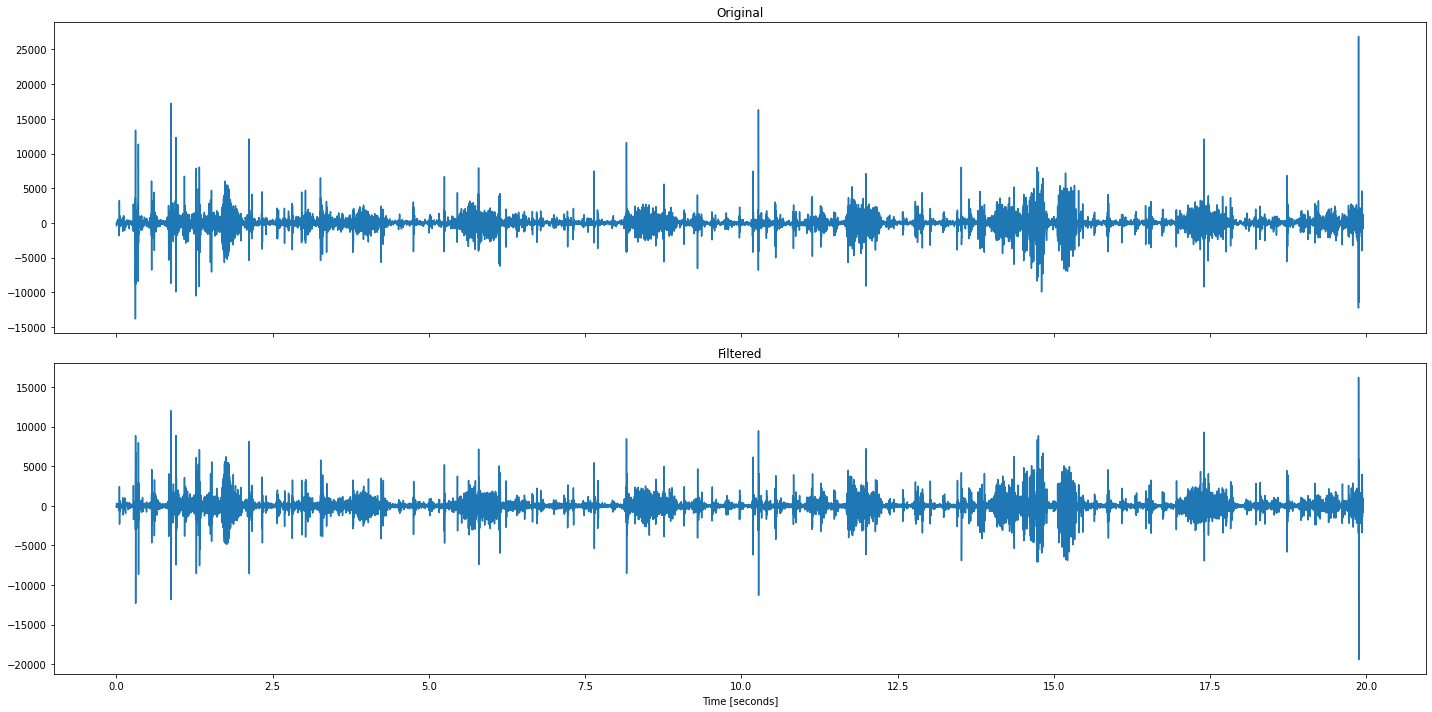

In [ ]:
import scipy as sp, scipy.signal
import librosa

# data_folder = "C:/Users/lumin/Desktop/Work/20212/Data/physionet.org/files/circor-heart-sound/1.0.3/training_data"
filename = "C:/Users/lumin/Desktop/Work/20212/Data/physionet.org/files/circor-heart-sound/1.0.3/training_data/9983_MV.wav"

NEW_SAMPLING_RATE = 1000
HIGH_CUT_FREQ = 400
LOW_CUT_FREQ = 25

frequency, recording = sp.io.wavfile.read(filename)

# Resampling file to 1000 Hz
scale = NEW_SAMPLING_RATE / frequency
# calculate new length of sample
nsamples = round(len(recording) * scale)
recording = sp.signal.resample(recording, nsamples)

# t = np.linspace(0, 1, 1000, False)  # 1 second
T = nsamples / NEW_SAMPLING_RATE
t = np.linspace(0, T, nsamples, endpoint=False)

rcParams['figure.figsize'] = 20, 10
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(t, recording)
ax1.set_title('Original')

filtered = butter_bandpass_filter(recording, LOW_CUT_FREQ, HIGH_CUT_FREQ, NEW_SAMPLING_RATE, order=6)
ax2.plot(t, filtered)
ax2.set_title('Filtered')
ax2.set_xlabel('Time [seconds]')
plt.tight_layout()
plt.show()


### Remove peaks

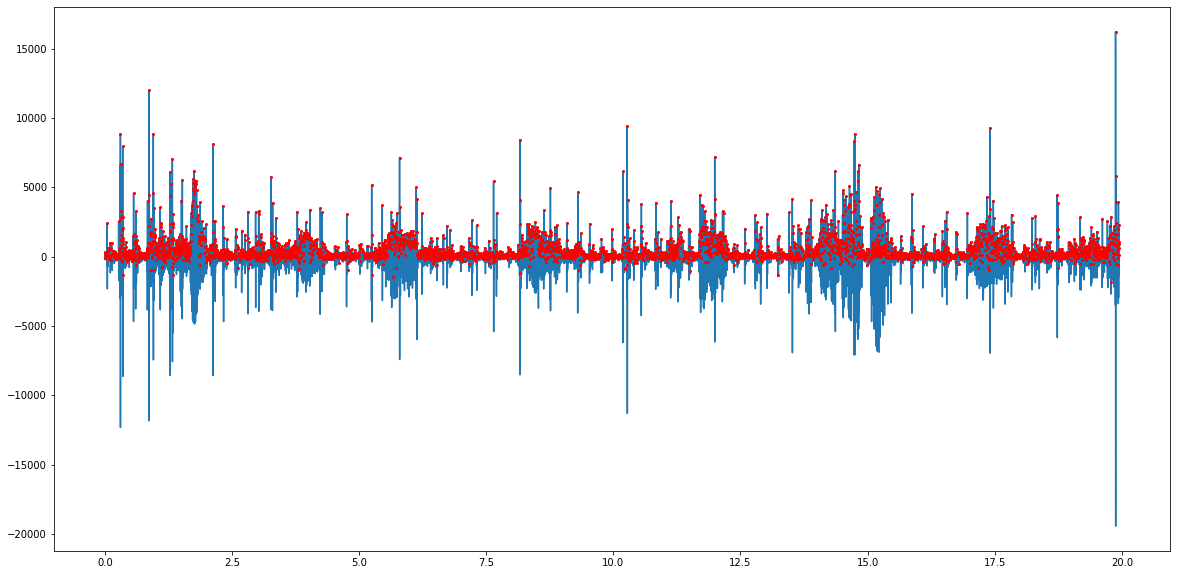

In [9]:
plt.plot(t, filtered)

peaks, properties = sp.signal.find_peaks(filtered)
for i in range(len(peaks)):
    plt.plot(peaks[i] / NEW_SAMPLING_RATE, filtered[peaks[i]], marker='o', markersize=2, c='red')
    filtered[peaks[i]] = np.nan

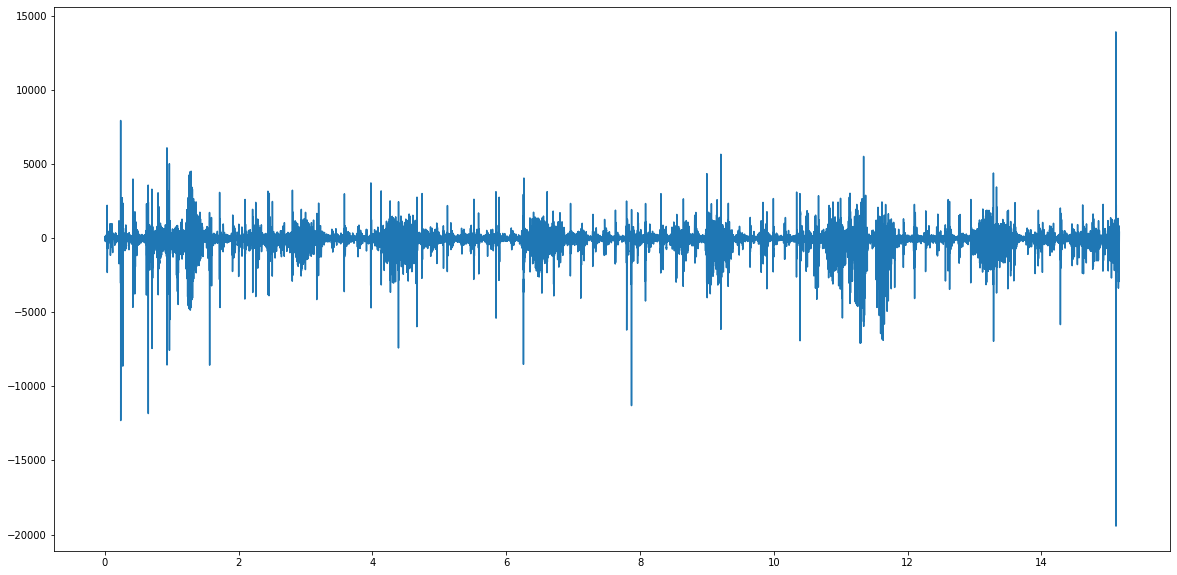

In [10]:
preprocessed = filtered[np.logical_not(np.isnan(filtered))]
nsamples = len(preprocessed)

plt.plot(np.linspace(0, nsamples / NEW_SAMPLING_RATE, nsamples), preprocessed)

In [7]:
# from scipy.io.wavfile import write

# samplerate = 44100; fs = 100
# t = np.linspace(0., 1., samplerate)
# amplitude = np.iinfo(np.int16).max
# data = amplitude * np.sin(2. * np.pi * fs * t)
# write("example.wav", samplerate, data.astype(np.int16))

### Split data into Train Test Val Sets

In [3]:
import os
import shutil
from helper_code import *

DATA_FOLDER = "C:/Users/lumin/Desktop/Work/20212/Data/physionet.org/files/circor-heart-sound/1.0.3/training_data/"
OUTPUT_FOLDER = "C:/Users/lumin/Desktop/Work/20212/Data/circor-heart-sound"

In [5]:
# Find the patient data files.
patient_files = find_patient_files(DATA_FOLDER)
num_patient_files = len(patient_files)

# Create a folder for the splitted data if one does not already exist
target_output_folder = os.path.join(OUTPUT_FOLDER, 'unsplitted')
os.makedirs(target_output_folder, exist_ok=True)

murmur_classes = ['Present', 'Unknown', 'Absent']
num_murmur_classes = len(murmur_classes)
outcome_classes = ['Abnormal', 'Normal']
num_outcome_classes = len(outcome_classes)

os.makedirs(os.path.join(target_output_folder, 'Present'), exist_ok=True)
os.makedirs(os.path.join(target_output_folder, 'Unknown'), exist_ok=True)
os.makedirs(os.path.join(target_output_folder, 'Absent'), exist_ok=True)

for i in range(num_patient_files):
    print('    {}/{}...'.format(i+1, num_patient_files))

    # Load the current patient data and recordings.
    current_patient_data = load_patient_data(patient_files[i])

    # Extract labels 
    current_murmur = get_murmur(current_patient_data)
    destination_folder = os.path.join(target_output_folder, current_murmur)
    patient_id = get_patient_id(current_patient_data)
    patient_file = os.path.join(DATA_FOLDER, patient_id + '.txt')
    shutil.copy(patient_file, destination_folder)

    num_locations = get_num_locations(current_patient_data)
    recording_information = current_patient_data.split('\n')[1:num_locations+1]

    for j in range(num_locations):
        entries = recording_information[j].split(' ')
        for filename in entries[1:]:
            shutil.copy(os.path.join(DATA_FOLDER, filename), os.path.join(destination_folder, filename))

    1/942...
    2/942...
    3/942...
    4/942...
    5/942...
    6/942...
    7/942...
    8/942...
    9/942...
    10/942...
    11/942...
    12/942...
    13/942...
    14/942...
    15/942...
    16/942...
    17/942...
    18/942...
    19/942...
    20/942...
    21/942...
    22/942...
    23/942...
    24/942...
    25/942...
    26/942...
    27/942...
    28/942...
    29/942...
    30/942...
    31/942...
    32/942...
    33/942...
    34/942...
    35/942...
    36/942...
    37/942...
    38/942...
    39/942...
    40/942...
    41/942...
    42/942...
    43/942...
    44/942...
    45/942...
    46/942...
    47/942...
    48/942...
    49/942...
    50/942...
    51/942...
    52/942...
    53/942...
    54/942...
    55/942...
    56/942...
    57/942...
    58/942...
    59/942...
    60/942...
    61/942...
    62/942...
    63/942...
    64/942...
    65/942...
    66/942...
    67/942...
    68/942...
    69/942...
    70/942...
    71/942...
    72/942...
 

In [4]:
import splitfolders

data_folder = os.path.join(OUTPUT_FOLDER, 'unsplitted')
output_folder = os.path.join(OUTPUT_FOLDER, 'splitted')

splitfolders.ratio(data_folder, output=output_folder, seed=1337, ratio=(.8, 0, .2)) 

In [19]:
# Mix classes 

from os import listdir, walk, makedirs
from os.path import isfile, dirname, join

splitted_data_path = join(OUTPUT_FOLDER, 'splitted')
output_path = join(OUTPUT_FOLDER, "final")

for set in listdir(splitted_data_path):
    set_path = join(output_path, set)
    makedirs(set_path, exist_ok=True)
    for root, dirs, files in walk(join(splitted_data_path, set)):
        for f in files:
            file_path = join(root, f)
            shutil.copy2(file_path, set_path)
    # print(set)

In [20]:
# Clean up to make sure that files are in the same folder with their folder file
from os.path import exists

other_set = {
    'train' : 'test',
    'test' : 'train'
}

for set in listdir(output_path):
    for root, dirs, files in walk(join(output_path, set)):
        for f in files:
            if '.txt' not in f: 
                patient_id = f.split('_')[0]
                if not exists(join(root, patient_id+'.txt')):
                    shutil.move(join(root, f), join(output_path, other_set[set]))